In [71]:
import os
import numpy as np
from scipy.optimize import brentq

In [72]:
from typing import List, Tuple

def load_dataset(root_folder: str) -> Tuple[List[str], int]:
    folders = os.listdir(root_folder)
    dataset = []
    labels = []

    for folder in folders:
        folder_path = os.path.join(root_folder, folder)
        files = os.listdir(folder_path)
        files = [os.path.join(folder_path, file) for file in files]
        dataset += files

        for file in files:
            filename = os.path.splitext(file)[0]
            if filename.endswith("cafe"):
                labels.append(1)
            elif filename.endswith("highway"):
                labels.append(2)
            elif filename.endswith("park"):
                labels.append(3)
            else:
                labels.append(0)

    return dataset, labels

In [ ]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

ni, nj = 5, 50
smx = np.array([softmax(np.random.rand(nj)) for _ in range(ni)])
wers = np.array([np.random.uniform(0, 1, nj) for _ in range(ni)])
predictions = [[f"p-{i}-{j}" for j in range(nj)] for i in range(ni)]

In [111]:
# load the data

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

"""
The idea is that for samples on the highway confidence scores are lower.
No idea how to model the WERs.

Calculate coverage and evaluation metrics.
"""

n, ny = 5, 50
smx = [softmax(np.random.rand(ny)) for _ in range(n)]
smx = np.array(smx)

wers = [np.random.uniform(0, 1, ny) for _ in range(n)]
wers = np.array(wers)

predictions = [[f"p-{i}-{j}" for j in range(ny)] for i in range(n)]

# dataset, _ = load_dataset(os.path.join("..", "2023-12-04-HMI-dataset-predictions"))
# folder = "agtbv"
# dataset = [dpath for dpath in dataset if folder in dpath]

In [60]:
smx[:, :5], wers[:, :5]

(array([[0.01778398, 0.01458857, 0.0184689 , 0.02263611, 0.02352926],
        [0.02743787, 0.01161716, 0.02112399, 0.01508731, 0.02618119],
        [0.01526051, 0.0255717 , 0.01991466, 0.01638158, 0.01678866],
        [0.02462466, 0.02264838, 0.01507506, 0.01186103, 0.02710688],
        [0.0205059 , 0.01826211, 0.0137314 , 0.01283853, 0.01517562]]),
 array([[0.71652463, 0.61148397, 0.6692427 , 0.69128523, 0.11889995],
        [0.6196207 , 0.51858121, 0.94043086, 0.63826918, 0.82467735],
        [0.24589271, 0.51789722, 0.31534971, 0.11684404, 0.40450069],
        [0.55923374, 0.97639261, 0.08754338, 0.80168132, 0.10012548],
        [0.25402137, 0.16030538, 0.26100657, 0.57182727, 0.96858447]]))

In [209]:
# problem setup

threshold = 0.9
n = smx.shape[0]
alpha = 0.5

B = 1

# define the loss function

"""
non increasing loss function
plot loss function against lambda
"""

def loss_fn(word_error_rates):
    arr = np.array([int(np.any(w < threshold)) for w in word_error_rates])
    return arr.mean()

In [176]:
def lamhat_threshold(lam):
    prefix_sums = np.cumsum(smx, axis=1)
    indexes = np.argmin(prefix_sums < lam, axis=1) - 1

    arr = []
    for idx in range(wers.shape[0]):
        if indexes[idx] == -1:
            arr.append(np.array([]))
        else:
            arr.append(wers[idx][:indexes[idx]])

    return loss_fn(arr) - ((n+1)/n*alpha - 1/(n+1))

# brentq(lamhat_threshold, 0, 1)

In [177]:
def c_lam(lam, smx, wers):
    """Compute prediction set indexes using lambda"""
    prefix_sums = np.cumsum(smx, axis=1)
    threshold_indexes = np.zeros(prefix_sums.shape[0], dtype=int)
    for idx, row in enumerate(prefix_sums):
        threshold_idx = np.argmax(row >= lam)
        threshold_indexes[idx] = threshold_idx if row[threshold_idx] >= lam else row.shape[0] - 1
    return threshold_indexes

In [205]:
# Use the computed indexes to construct prediction set

idxs = c_lam(0.1, smx, wers)
prediction_wers = []
for idx, threshold_idx in enumerate(idxs):
    prediction_wers.append(wers[idx][:threshold_idx])
    
prediction_wers

[array([0.02637078, 0.29934512, 0.3284163 , 0.82811785]),
 array([0.71746224, 0.09669782, 0.39272025, 0.33300676]),
 array([0.67052465, 0.84633873, 0.42391286, 0.41769981, 0.34590247,
        0.02240038]),
 array([0.87033042, 0.86609194, 0.01665355, 0.57454199]),
 array([0.98120339, 0.15572309, 0.11673318, 0.79118194, 0.93349786])]

In [210]:
def wer_empirical_risk(word_error_rates, wer_target):
    """Compute the empirical risk on the calibration data"""
    loss = [int(np.all(w >= wer_target)) for w in word_error_rates]
    return sum(loss)/len(loss)
    
idxs = c_lam(0.02, smx, wers)
prediction_wers = []
for idx, threshold_idx in enumerate(idxs):
    prediction_wers.append(wers[idx][:threshold_idx])
    
wer_empirical_risk(prediction_wers, 0.1)

1.0

In [217]:
def conformal_risk_control(lam):
    idxs = c_lam(lam, smx, wers)
    prediction_wers = []
    for idx, threshold_idx in enumerate(idxs):
        prediction_wers.append(wers[idx][:threshold_idx])

    return wer_empirical_risk(prediction_wers, threshold) - ((n+1)/n*alpha - 1/(n+1))

def compute_lamhat(smx, wers):
    """Search for value of lambda that controls the WER"""
    return brentq(conformal_risk_control, 0, 1)

compute_lamhat(smx, wers)

0.025717707986041692

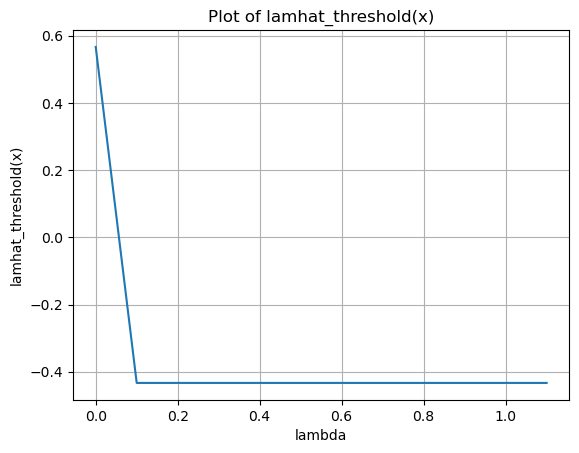

In [218]:
import matplotlib.pyplot as plt

# Generate x values at 0.1 intervals
x_values = np.arange(0, 1.2, 0.1)

# Compute y values using the function
y_values = [conformal_risk_control(x) for x in x_values]

# Plot the function
plt.plot(x_values, y_values)
plt.xlabel('lambda')
plt.ylabel('lamhat_threshold(x)')
plt.title('Plot of lamhat_threshold(x)')
plt.grid(True)
plt.show()

In [47]:
prefix_sums = np.cumsum(softmax_values, axis=1)
a = prefix_sums < 0.1
np.argmin(a, axis=1) - 1
# wers_values[a]

array([3, 3])

In [28]:
lamhat

0.02137353799857963